# structure
AiiDA vasp WorkChain calls calculations

#  Settings

1. change CODE_STRING = 'vasp@iceberg_direct' according to your environment.
1. change POTENTIAL_FAMILY = 'PBE.54' according to your environment.


In [1]:
import numpy as np
from aiida.common.extendeddicts import AttributeDict
from aiida.manage.configuration import load_profile
from aiida.orm import Bool, Str, Code, Int, Float
from aiida.plugins import DataFactory, WorkflowFactory
from aiida.engine import submit
load_profile()


def launch_aiida(structure, code_string, resources,
                 label="SiC VASP calculation"):
    Dict = DataFactory('dict')
    KpointsData = DataFactory("array.kpoints")

    incar_dict = {'incar':{
        'PREC': 'Accurate',
        'IBRION': -1,
        'EDIFF': 1e-8,
        'NELMIN': 5,
        'NELM': 100,
        'ENCUT': 500,
        'IALGO': 38,
        'ISMEAR': 0,
        'SIGMA': 0.01,
        'LREAL': False,
        'LCHARG': False,
        'LWAVE': False,
        'lorbit': 11, # for PDOS
    }
    }

    kpoints = KpointsData()
    kpoints.set_kpoints_mesh([9,9,5], offset=[0, 0, 0.5])

    options = {'resources': resources,
               'account': '',
               'max_memory_kb': 1024000,
               'max_wallclock_seconds': 3600 * 10}

    potential_family = 'PBE.54'
    potential_mapping = {'Si': 'Si', 'C': 'C'}

    parser_settings = {'add_energies': True,
                       'add_forces': True,
                       'add_stress': True,
                       'add_dos': True, 
                       'add_trajectory': True,
                       'add_site_magnetixation': True
                      }

    code = Code.get_from_string(code_string)
    Workflow = WorkflowFactory('vasp.vasp')
    builder = Workflow.get_builder()
    builder.code = code
    builder.parameters = Dict(dict=incar_dict)
    builder.structure = structure
    builder.settings = Dict(dict={'parser_settings': parser_settings})
    builder.potential_family = Str(potential_family)
    builder.potential_mapping = Dict(dict=potential_mapping)
    builder.kpoints = kpoints
    builder.options = Dict(dict=options)
    builder.metadata.label = label
    builder.metadata.description = label
    builder.clean_workdir = Bool(False)

    node = submit(builder)
    return node


def get_structure_SiC():
    """Set up SiC cell

    Si C
       1.0
         3.0920072935808083    0.0000000000000000    0.0000000000000000
        -1.5460036467904041    2.6777568649277486    0.0000000000000000
         0.0000000000000000    0.0000000000000000    5.0733470000000001
     Si C
       2   2
    Direct
       0.3333333333333333  0.6666666666666665  0.4995889999999998
       0.6666666666666667  0.3333333333333333  0.9995889999999998
       0.3333333333333333  0.6666666666666665  0.8754109999999998
       0.6666666666666667  0.3333333333333333  0.3754109999999997

    """

    StructureData = DataFactory('structure')
    a = 3.092
    c = 5.073
    lattice = [[a, 0, 0],
               [-a / 2, a / 2 * np.sqrt(3), 0],
               [0, 0, c]]
    structure = StructureData(cell=lattice)
    for pos_direct, symbol in zip(
            ([1. / 3, 2. / 3, 0],
             [2. / 3, 1. / 3, 0.5],
             [1. / 3, 2. / 3, 0.375822],
             [2. / 3, 1. / 3, 0.875822]), ('Si', 'Si', 'C', 'C')):
        pos_cartesian = np.dot(pos_direct, lattice)
        structure.append_atom(position=pos_cartesian, symbols=symbol)
    return structure


def main(code_string, resources):
    structure = get_structure_SiC()
    return launch_aiida(structure, code_string, resources)


if __name__ == '__main__':
    code_string = 'vasp5_iceberg'
    resources = {'num_machines': 1, 'num_mpiprocs_per_machine': 10}
    workchain = main(code_string, resources)

In [2]:
import time
while not workchain.is_terminated:
    print(workchain.exit_message, "sleep 5 sec")
    time.sleep(5)
print(workchain.is_finished_ok)

None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
None sleep 5 sec
True


In [3]:
workchain.outputs.energies.attributes

{'array|electronic_steps': [1],
 'array|energy_extrapolated': [1],
 'array|energy_extrapolated_final': [1]}

In [4]:
workchain.outputs.energies.get_array("energy_extrapolated")

array([-30.11034064])

In [5]:
workchain.outputs.forces.attributes

{'array|final': [4, 3]}

In [6]:
workchain.outputs.forces.get_array("final")

array([[-0.        , -0.        , -0.00412725],
       [-0.        , -0.        , -0.00412725],
       [-0.        ,  0.        ,  0.00412725],
       [ 0.        , -0.        ,  0.00412725]])

In [7]:
workchain.outputs.stress.attributes

{'array|final': [3, 3]}

In [8]:
workchain.outputs.stress.get_array('final')

array([[-0.44560133,  0.        ,  0.        ],
       [ 0.        , -0.44560133,  0.        ],
       [ 0.        ,  0.        ,  1.11486712]])

In [9]:
workchain.outputs.dos

<ArrayData: uuid: 0767c2f0-9608-4afb-b625-6a2b82e7a0d2 (pk: 2104)>

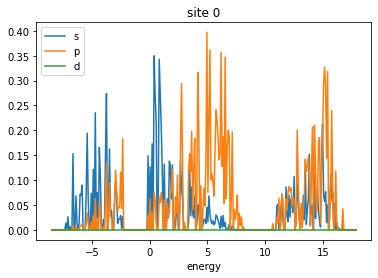

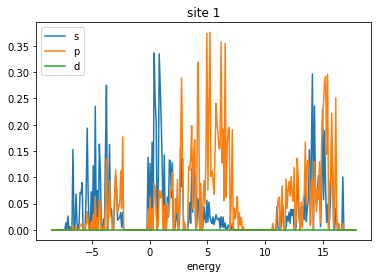

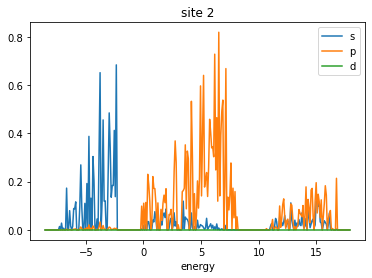

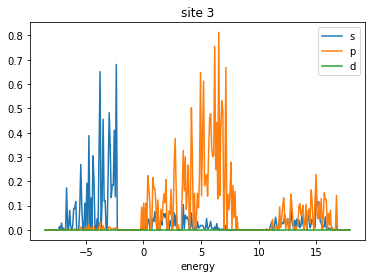

In [10]:
def outputs_pdos_plot(dos):
    energy = dos.get_array("energy")
    pdos = dos.get_array("pdos")

    import numpy as np
    import matplotlib.pyplot as plt
    for i in range(pdos.shape[0]):
        fig, ax = plt.subplots()
        ax.plot(energy,pdos[i,:,0], label="s")
        ax.plot(energy,np.sum(pdos[i,:,1:4], axis=1), label="p")
        ax.plot(energy,np.sum(pdos[i,:,4:], axis=1), label="d")
        ax.legend()
        ax.set_xlabel("energy")
        ax.set_title("site %d" % i)
        
outputs_pdos_plot(workchain.outputs.dos)

In [11]:
from aiida.orm.nodes.process.calculation.calcjob import CalcJobNode
import time
waitsec =  5
future = None
while future is None:
    for node in workchain.get_outgoing().all_nodes():
        if isinstance(node,CalcJobNode):
            print(node)
            future = node
            break
    time.sleep(waitsec)

uuid: 3f3e9f44-89b0-4bbf-a21f-6a53b58d385a (pk: 2100) (aiida.calculations:vasp.vasp)


In [12]:
from getnodefile import CopyInputOutputFiles
copyvaspio = CopyInputOutputFiles(["INCAR","KPOINTS","POSCAR"],
                                  ["CONTCAR","OUTCAR","DOSCAR","vasprun.xml"])
pk = future.pk
dirname = "VASP_RESULT_{}".format(pk)
print(dirname)
import os
if not os.path.isdir(dirname):
    os.mkdir(dirname)
copyvaspio.copy(future, dirname)

VASP_RESULT_2100


0

In [13]:
!ls $dirname

CONTCAR  DOSCAR  INCAR	KPOINTS  OUTCAR  POSCAR  vasprun.xml
